# COSC 4P96 Assignment 1: Supervised to Semi-Supervised Learning
Elias Switzer, 7419997

Set Parameters

In [1]:
#Random seed
seed = 0

# Model parameters
init_type = "he" #random_uniform, random_normal, or he

Imports and random seeds

In [2]:
import torch
torch.manual_seed(seed)

from torchvision import datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import random_split, DataLoader

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

Device configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # will run on GPU if available
print("Using device: ", device)

Using device:  cuda


Load CIFAR-10 dataset

In [4]:
transform = v2.Compose([
    v2.ToTensor()
])

# TODO: Move data prep to its own python script

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100.0%


Apply the data transformations

In [ ]:
from data_prep import compute_mean_std, compute_min_max, MinMaxScaling

data_mean, data_std = compute_mean_std(dataset)
data_min, data_max = compute_min_max(dataset)

dataset.transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=data_mean, std=data_std), # Apply z-score normalization
    MinMaxScaling(data_min, data_max, 0, 1), # Apply min-max scaling to [0,1]

    v2.RandomHorizontalFlip(p=0.5), # add ability to control these parameters later
    v2.RandomCrop((32,32)),
    v2.GaussianNoise(mean=0, sigma=0.1),
    v2.ColorJitter()
])

Split data

In [6]:
# This custom split is from the official training data and does not use the official testing data
generator = torch.Generator().manual_seed(seed)

# Split into training, validation and testing data
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

# Split into labeled and unlabeled for semi-supervised setup
labeled_training_set, unlabeled_training_set = random_split(train_set, [0.2, 0.8], generator=generator)

# Split into initial training and validation (from the labeled data)
initial_training_set, initial_validation_set = random_split(labeled_training_set, [0.75, 0.25], generator=generator)

Preview the data

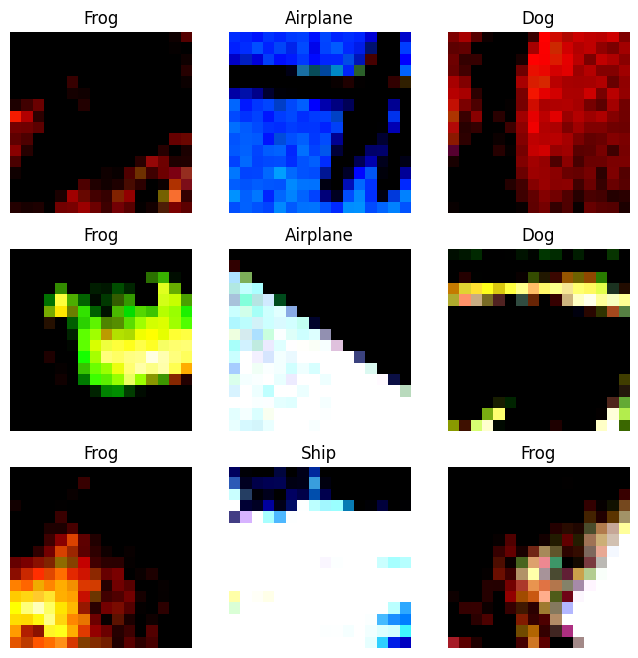

In [7]:
import matplotlib.pyplot as plt

labels = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

In [11]:
x,_ = dataset[0]
print(x.shape)

torch.Size([3, 16, 16])


Create data loaders

In [8]:
initial_train_loader = DataLoader(initial_training_set, batch_size=64, shuffle=True)
initial_val_loader = DataLoader(initial_validation_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

Configure supervised neural network, weight initialization, optimizer and loss function

In [9]:
from model_supervised import SupervisedNetwork, init_weights
import torch.nn as nn
import torch.optim as optim

# TODO: add more parameter options
lr = 0.01 # experiment with values in [0.001, 0.1]
momentum = 0.9 # experiment with values in [0.5, 0.99]

model = SupervisedNetwork()
model.apply(lambda m: init_weights(m, type=init_type))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Train and validate baseline supervised neural network

In [10]:
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for images, labels in initial_train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # zero gradients

        outputs = model(images)  # forward pass
        loss = criterion(outputs, labels)

        loss.backward() # backpropigate error
        optimizer.step() # update parameters

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in initial_val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    val_loss /= total
    val_acc = correct / total

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | ",
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}"
    )

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 2048x256)